# 4 užduotis
## Matas Amšiejus
## DM2

Straipsnis (ar tutorial), kuriuo rėmiausi
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

## 1. Darbo pradžia


### 1.1. Bibliotekų importavimas

In [ ]:
import tensorflow.keras
#Nuadosime paprasciausia konvoliuciniu tinklu modeli, del to importuojame Sequantial
from tensorflow.keras.models import Sequential
#Importavimas sluoksniu
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, MaxPooling2D, Conv2D
#Modelio testavimui
from keras.models import load_model

#Vaizdai tai masyvai, del to reikia:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

#Sarasu sumaisymui
import random
#Grafiku piesimui
from matplotlib import pyplot as plt

### 1.2 Duomenų nuskaitymas ir tvarkymas

Pagal https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data yra pasakyta, kad reikiamus duomenis galima pasiimti iš keras bibliotekos. Parašius *tensorflowf.keras.datasets.cifar10.load_data()* bus grąžinama **"Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test)."** Taigi duomenis nuskaitysiu taip, kaip jie yra paduoti. mok_duom bus mokymo paveiksliukai, mok_pav - kas juose vaizduojama (žr. nuorodą). Su test analogiškai. Mokymo duomenų bus 50 000 , o testavimo - 10 000.

In [ ]:
(mok_duom, mok_pav), (test_duom, test_pav) = tensorflow.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


Iš žemiau esančio kodo matome, kad mokymo duomenų yra 50 000 eilučių, tose eilutėse yra priskirta 32x32 dydžio masyvai (atitinkantys paveiksliuko pikselių skaičių) kur kiekvienam pikseliui yra priskiriamos 3 reikšmės - RGB (red green blue).

In [ ]:
mok_duom.shape

(50000, 32, 32, 3)

In [ ]:
#sujungiame visus duomenis
duom = np.concatenate((mok_duom, test_duom), axis = 0)
pav = np.concatenate((mok_pav, test_pav), axis = 0)

In [ ]:
#sujungiame duomenis su klasemis
sarasas = zip(duom,pav)
zipped = list(sarasas)
#surusiuojame pagal klases
res = sorted(zipped, key = lambda x: x[1])

In [ ]:
#unzip'iname, kur nduom bus visi surusiuoti duomenis, npav - pavadinimai
nduom, npav = zip(*res)
nduom = np.asarray(nduom)
npav = np.asarray(npav)

In [ ]:
#Pasirenkamas mokymo - testavimo duomenu santykis
sant = 0.8

In [ ]:
#sukuriame testavimo masyva (2 elementai ideti tam, kad sukurti forma, paskui bus istrinti)
test_duom = nduom[0:2]
#sukuriame seka, kuri eis per kievienos klases ribas (ju bus 10)
klas_intervalai = np.arange(start = 0, stop = 54001, step = 6000)
#inicijuojame pseudo atsitiktini skaiciu generatoriu
rng = np.random.default_rng(12345)
#sukuriame indeksu masyva, kuris parodys kuriu elementu neimti i mokymo masyva
mega_indeksai = np.array([0])

#sukame cikla per klases ribas
for startas in klas_intervalai:
  #sukuriame laikina kintamaji, kuris talpina visus imanomus indeksus tiriamai klasei
  temp = np.arange(start = startas, stop = startas + 6000)
  #is imanomu indeksu atrenkame atsitiktinius indeksus (tik testavimo (nes maziau skaiciavimo))
  indeksai = rng.choice(a = temp, size=int(round(6000*(1-sant),0)), replace = False)
  #tuo paciu kaupiame indeksu masyva
  mega_indeksai = np.append(mega_indeksai, indeksai)
  #pridedame testavimo duomenis
  test_duom = np.concatenate((test_duom, nduom[indeksai]), axis = 0)

In [ ]:
#ismetame is masyvu reiksmes, kurias buvome ideje pradzioje:
test_duom = np.delete(test_duom, (0,1), axis = 0)
test_duom.shape

(12000, 32, 32, 3)

In [ ]:
#Sukuriame atitinkama pavadinimu masyva testavimo aibei
kiek = np.repeat(int(round(6000*(1-sant),0)), 10)
test_pav = np.repeat([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]], kiek, axis = 0)
test_pav.shape

(12000, 1)

In [ ]:
#istriname pirma savo irasita ranka reiksme (nereikalinga)
mega_indeksai = np.delete(mega_indeksai, (0))

#I mokymo duomenu aibe paimame tik duomenis, kuriu nera testavimo duomenu aibeje
mok_duom = np.delete(nduom, (mega_indeksai), axis = 0)
mok_duom.shape

(48000, 32, 32, 3)

In [ ]:
#Sukuriame atitinkama pavadinimu masyva mokymo aibei
kiek = np.repeat(int(round(6000*(sant),0)), 10)
mok_pav = np.repeat([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]], kiek, axis = 0)
mok_pav.shape

(48000, 1)

In [ ]:
#Dabar reikes sumaisyti musu mokymo ir testavimo aibes
#Sudarome mokymo ir testavimo grupes
sarasas_mok = zip(mok_duom,mok_pav)
zipped_mok = list(sarasas_mok)

sarasas_test = zip(test_duom, test_pav)
zipped_test = list(sarasas_test)

In [ ]:
#Ismetome sarasu elementus atsitiktinai (duomenys ir pavadinimai suristi, todel bus galima atsekti iraso klases)
random.shuffle(zipped_mok)
random.shuffle(zipped_test)

In [ ]:
#issklaidziame zip
mok_duom, mok_pav = zip(*zipped_mok)
mok_duom = np.asarray(mok_duom)
mok_pav = np.asarray(mok_pav)

test_duom, test_pav = zip(*zipped_test)
test_duom = np.asarray(test_duom)
test_pav = np.asarray(test_pav)

In [ ]:
#Patikriname atsitiktinuma
print(mok_pav[0:5])
print(mok_pav.shape, "\n")
print(test_pav[0:5])
print(test_pav.shape)

[[5]
 [5]
 [4]
 [2]
 [8]]
(48000, 1) 

[[0]
 [4]
 [2]
 [6]
 [4]]
(12000, 1)


Normuojame mokymosi duomenis.

In [ ]:
#Pirma pakeiciame i float, kad butu galima dalinti ir gauti skaiciu po kablelio
mok_duom = mok_duom.astype('float32')
test_duom = test_duom.astype('float32')

#Normuojame is maksimalios RGB vertes (kuri yra 255)
mok_duom = mok_duom / 255.0
test_duom = test_duom / 255.0

Taip pat sutvarkome pavadinimų (klasių) masyvus (hot encoding).

In [ ]:
#Kiek klasiu t. y. kas vaizduojama paveiksleliuose (musu atveju 10 objektu)
n_klasiu = 10
#Keiciame, kad vietoje skaiciaus (ar kategorinio kintamojo) mes turetume binarini masyva, kur kiekvienas stulpelis pazymetas 1 reiskia, kad tai "tas" vaizdas
mok_pav = tensorflow.keras.utils.to_categorical(mok_pav)
test_pav = tensorflow.keras.utils.to_categorical(test_pav)
mok_pav

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 2. Modelio nustatymas ir eksperimentavimas

Naudosiu VGGNet bazę modelio kūrimui.

### 2.1. 1 bloko VGG modelis

In [ ]:
model_1 = Sequential()
#Pridedame 2 konvoliucijos sluoksnius, kur 32 filtrai kuriu dydis 3x3, aktyvacijos funkcija relu.
#Padding naudojamas konvoliucijos sluoksniuse kad isvesciu pozymiu zemelapio plotis ir aukstis atitiktu ivesties dimensijas (uzpildoma 0).
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#Sujungimo sluoksnis (musu atveju naudojama max pooling - maskimalus sujungimas)
model_1.add(MaxPooling2D((2, 2)))
#Auksciau buvo relizuotas vienas "blokas"

#Pries pilnai sujungto sluoksnio konstravima atliekama flatten operacija, kad paveiksleliu pozymiu zemelapiu matricas paverstume i vektorius
model_1.add(Flatten())

#Konstruojame pilnai sujungta sluoksni. Pirma imame 128 pasleptus neuronus sluoksnyje su aktyvacijos f-ja ReLu
model_1.add(Dense(128, activation='relu'))
#Dabar pridedame isejimo sluoksni, kur neuronu kiekis turi sutapti su klasiu skaiciumi (musu atveju 10). Aktyvacijos f-ja softmax (ji dazniausiai naudojama, geriausia praktika)
model_1.add(Dense(n_klasiu, activation='softmax'))

### 2.2. 2 bloku VGG modelis

In [ ]:
model_2 = Sequential()
#1 blokas
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2)))
#Auksciau buvo relizuotas vienas "blokas". Padarysime dar 2 "blokus", kur filtru vis dauges dvigubai

#2 blokas
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D((2, 2)))


model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(n_klasiu, activation='softmax'))

### 2.3. 3 bloku VGG modelis

In [ ]:
model_3 = Sequential()
#1 blokas
model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D((2, 2)))

#2 blokas
model_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D((2, 2)))

#3 blokas
model_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D((2, 2)))


model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(n_klasiu, activation='softmax'))

### 2.4. Kompiliavimo modelis

In [ ]:
#Pabandykime palyginti su Adam algoritmu, kuris skaitosi vienu geriausiu optimizavimo algoritmu
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 2.5. Papildomos funkcijos

Tam, kad Google Colab naudotų GPU mokymui (žymiai paspartina mokymosi procesą) pirma sutvarkau nustatymus: Edit -> NoteBook Settings -> įjungiu GPU. Žemiau kode patikrinu, ar rastas GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Grafikas, skirtas įvertinti klasifikavimo tikslumą.

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history): 
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Modelio tikslumas')
  plt.ylabel('Klasifikavimo tikslumas')
  plt.xlabel('Epochų skaičius')
  plt.legend(['Mokymosi', 'Testavimo'])
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Modelio nuostoliai')
  plt.ylabel('Nuostoliai')
  plt.xlabel('Epochų skaičius')
  plt.legend(['Mokymosi', 'Testavimo'])
  plt.show()

## 3. Modelio mokymai / testavimai

### 3.1. Pagal tinklo architektūrą

Atliekame modelio su vienu bloku mokymą ir testavimą

Epoch 1/10
375/375 [==============================] - 7s 18ms/step - loss: 1.5420 - accuracy: 0.4513 - val_loss: 1.2698 - val_accuracy: 0.5408
Epoch 2/10
375/375 [==============================] - 6s 17ms/step - loss: 1.1411 - accuracy: 0.6003 - val_loss: 1.1176 - val_accuracy: 0.6068
Epoch 3/10
375/375 [==============================] - 6s 17ms/step - loss: 0.9843 - accuracy: 0.6587 - val_loss: 0.9862 - val_accuracy: 0.6515
Epoch 4/10
375/375 [==============================] - 6s 17ms/step - loss: 0.8838 - accuracy: 0.6911 - val_loss: 1.0078 - val_accuracy: 0.6447
Epoch 5/10
375/375 [==============================] - 6s 17ms/step - loss: 0.8114 - accuracy: 0.7167 - val_loss: 0.9407 - val_accuracy: 0.6735
Epoch 6/10
375/375 [==============================] - 6s 17ms/step - loss: 0.7471 - accuracy: 0.7399 - val_loss: 0.9376 - val_accuracy: 0.6773
Epoch 7/10
375/375 [==============================] - 6s 17ms/step - loss: 0.6977 - accuracy: 0.7550 - val_loss: 0.9694 - val_accuracy: 0.6718

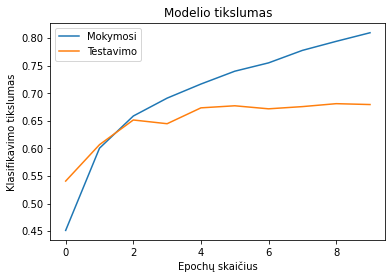

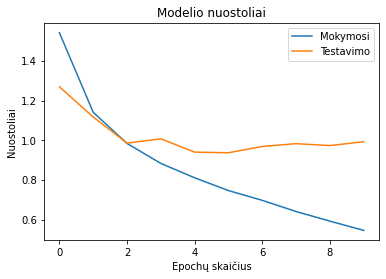

In [ ]:
istorija = model_1.fit(mok_duom, mok_pav, batch_size=128, epochs = 10, validation_data = (test_duom,test_pav), verbose = 1)
_, acc = model_1.evaluate(test_duom, test_pav)
print('> %.3f' % (acc * 100.0))
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

#Pastaba: rodo, kad atliktos tik 375 iteracijos. Google colab rodo tiek, nes cia iteracijos pasitelkiant batch, t. y. 
#viena iteracija - tai neuronų mokymo	proceso	dalis, kurios metu apdorojami įėjimų vektorių aibė,	kurios dydis paketo (batch) dydžiui.
#Taigi 375 x 128 = 48 000 - musu mokymosi aibes didumas

Atliekame modelio su dviejais blokais mokymą ir testavimą. Pirma sukompiliuojame modelį

In [ ]:
#Pabandykime palyginti su Adam algoritmu, kuris skaitosi vienu geriausiu optimizavimo algoritmu
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
375/375 [==============================] - 11s 26ms/step - loss: 1.5184 - accuracy: 0.4526 - val_loss: 1.2099 - val_accuracy: 0.5682
Epoch 2/10
375/375 [==============================] - 9s 25ms/step - loss: 1.0595 - accuracy: 0.6249 - val_loss: 1.0102 - val_accuracy: 0.6496
Epoch 3/10
375/375 [==============================] - 9s 25ms/step - loss: 0.8658 - accuracy: 0.6967 - val_loss: 0.8711 - val_accuracy: 0.6960
Epoch 4/10
375/375 [==============================] - 9s 25ms/step - loss: 0.7512 - accuracy: 0.7362 - val_loss: 0.8236 - val_accuracy: 0.7150
Epoch 5/10
375/375 [==============================] - 9s 25ms/step - loss: 0.6491 - accuracy: 0.7739 - val_loss: 0.7730 - val_accuracy: 0.7395
Epoch 6/10
375/375 [==============================] - 10s 26ms/step - loss: 0.5672 - accuracy: 0.8012 - val_loss: 0.7813 - val_accuracy: 0.7345
Epoch 7/10
375/375 [==============================] - 9s 25ms/step - loss: 0.4805 - accuracy: 0.8329 - val_loss: 0.7708 - val_accuracy: 0.74

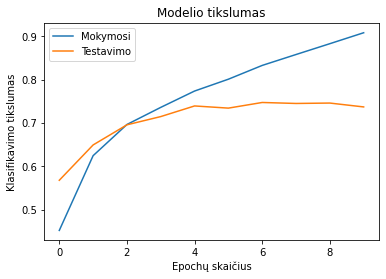

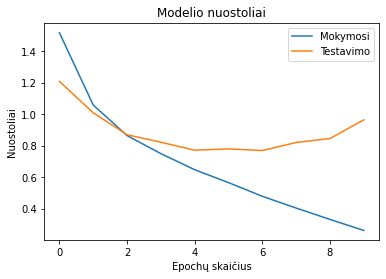

In [ ]:
istorija = model_2.fit(mok_duom, mok_pav, batch_size=128, epochs = 10, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Atliekame modelio su trijais blokais mokymą ir testavimą. Pirma sukompiliuojame modelį

In [ ]:
#Pabandykime palyginti su Adam algoritmu, kuris skaitosi vienu geriausiu optimizavimo algoritmu
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
375/375 [==============================] - 13s 33ms/step - loss: 1.5601 - accuracy: 0.4270 - val_loss: 1.1920 - val_accuracy: 0.5732
Epoch 2/10
375/375 [==============================] - 12s 32ms/step - loss: 1.0412 - accuracy: 0.6292 - val_loss: 0.9416 - val_accuracy: 0.6670
Epoch 3/10
375/375 [==============================] - 12s 32ms/step - loss: 0.8320 - accuracy: 0.7072 - val_loss: 0.8524 - val_accuracy: 0.7035
Epoch 4/10
375/375 [==============================] - 12s 32ms/step - loss: 0.6927 - accuracy: 0.7588 - val_loss: 0.7282 - val_accuracy: 0.7461
Epoch 5/10
375/375 [==============================] - 12s 32ms/step - loss: 0.5798 - accuracy: 0.7980 - val_loss: 0.7062 - val_accuracy: 0.7583
Epoch 6/10
375/375 [==============================] - 12s 32ms/step - loss: 0.4924 - accuracy: 0.8275 - val_loss: 0.6835 - val_accuracy: 0.7674
Epoch 7/10
375/375 [==============================] - 12s 33ms/step - loss: 0.4025 - accuracy: 0.8581 - val_loss: 0.7183 - val_accuracy:

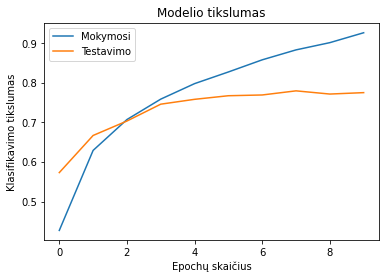

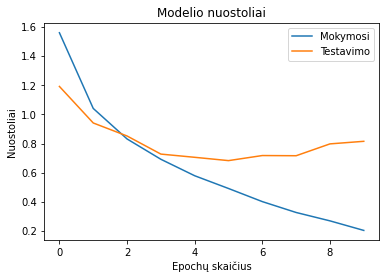

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 10, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Matome, kad tiksliausiai duomenis klasifikuoja modelis susidedantis iš 3 blokų, todėl toliau tęsime darbą su šiuo modeliu.

### 3.2. Pagal hyperparametrų reikšmes

#### 3.2.1. Keičiant epochų skaičių

Epoch 1/30
375/375 [==============================] - 13s 32ms/step - loss: 1.6103 - accuracy: 0.4045 - val_loss: 1.3258 - val_accuracy: 0.5163
Epoch 2/30
375/375 [==============================] - 12s 31ms/step - loss: 1.1068 - accuracy: 0.6062 - val_loss: 1.0342 - val_accuracy: 0.6405
Epoch 3/30
375/375 [==============================] - 12s 32ms/step - loss: 0.8698 - accuracy: 0.6960 - val_loss: 0.8320 - val_accuracy: 0.7062
Epoch 4/30
375/375 [==============================] - 12s 32ms/step - loss: 0.7332 - accuracy: 0.7417 - val_loss: 0.8219 - val_accuracy: 0.7172
Epoch 5/30
375/375 [==============================] - 12s 31ms/step - loss: 0.6240 - accuracy: 0.7804 - val_loss: 0.7280 - val_accuracy: 0.7487
Epoch 6/30
375/375 [==============================] - 12s 31ms/step - loss: 0.5312 - accuracy: 0.8149 - val_loss: 0.7378 - val_accuracy: 0.7527
Epoch 7/30
375/375 [==============================] - 12s 32ms/step - loss: 0.4609 - accuracy: 0.8403 - val_loss: 0.6585 - val_accuracy:

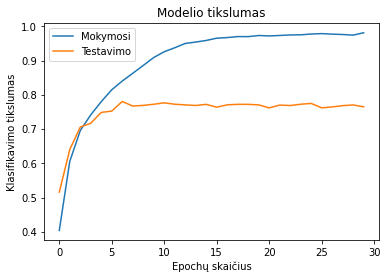

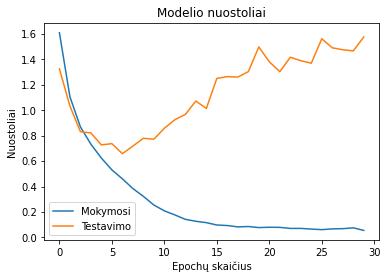

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 30, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Matome, kad didinant mokymosi epochų skaičių didėja tik mokymosi klasifikavimo tikslumas, tačiau testavimo duomenims jokios įtakos nebėra. Papildomai auga nuostoliai, todėl toliau paliksiu 15 epochų, tačiau bandysiu užkirsti kelią persimokymui atnaujinant modelį naudojant "dropout" - išmetimo sluosnį, kuris mokymosi iteracijoje atsitiktinai išmeta kelis neuronus.

In [ ]:
model_3 = Sequential()
#1 blokas
model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D((2, 2)))
#Paliekame 80 % neuronų sluoksnyje
model_3.add(Dropout(0.2))

#2 blokas
model_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.2))

#3 blokas
model_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(n_klasiu, activation='softmax'))

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
375/375 [==============================] - 17s 42ms/step - loss: 1.7198 - accuracy: 0.3610 - val_loss: 1.3040 - val_accuracy: 0.5278
Epoch 2/15
375/375 [==============================] - 16s 42ms/step - loss: 1.2173 - accuracy: 0.5647 - val_loss: 1.0335 - val_accuracy: 0.6290
Epoch 3/15
375/375 [==============================] - 16s 42ms/step - loss: 1.0265 - accuracy: 0.6397 - val_loss: 0.8987 - val_accuracy: 0.6771
Epoch 4/15
375/375 [==============================] - 16s 42ms/step - loss: 0.8975 - accuracy: 0.6874 - val_loss: 0.8474 - val_accuracy: 0.7005
Epoch 5/15
375/375 [==============================] - 16s 42ms/step - loss: 0.8133 - accuracy: 0.7154 - val_loss: 0.7752 - val_accuracy: 0.7274
Epoch 6/15
375/375 [==============================] - 16s 42ms/step - loss: 0.7298 - accuracy: 0.7451 - val_loss: 0.7120 - val_accuracy: 0.7511
Epoch 7/15
375/375 [==============================] - 16s 41ms/step - loss: 0.6760 - accuracy: 0.7636 - val_loss: 0.6763 - val_accuracy:

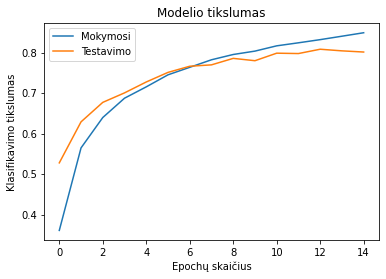

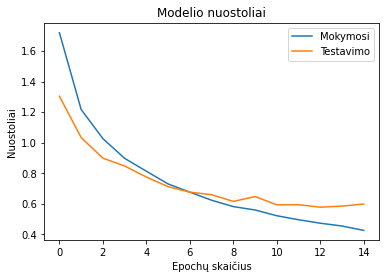

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Matome stiprų pokytį. Testavimo rezultatai ėmė pastoviai gerėti, nuostolių funkcija - mažėti, todėl tolimesniuose eksperimentuose paliksime šį nustatymą. Klasifikacimo koficienatas pakilo iki ~80 %.

#### 3.2.2. Keičiant paketo dydį

Epoch 1/15
94/94 [==============================] - 12s 117ms/step - loss: 1.8753 - accuracy: 0.3006 - val_loss: 1.5949 - val_accuracy: 0.4073
Epoch 2/15
94/94 [==============================] - 9s 97ms/step - loss: 1.5325 - accuracy: 0.4363 - val_loss: 1.3856 - val_accuracy: 0.4930
Epoch 3/15
94/94 [==============================] - 9s 96ms/step - loss: 1.3606 - accuracy: 0.5056 - val_loss: 1.2077 - val_accuracy: 0.5638
Epoch 4/15
94/94 [==============================] - 9s 97ms/step - loss: 1.2186 - accuracy: 0.5630 - val_loss: 1.0665 - val_accuracy: 0.6113
Epoch 5/15
94/94 [==============================] - 9s 96ms/step - loss: 1.1056 - accuracy: 0.6034 - val_loss: 0.9739 - val_accuracy: 0.6486
Epoch 6/15
94/94 [==============================] - 9s 97ms/step - loss: 1.0284 - accuracy: 0.6358 - val_loss: 0.9536 - val_accuracy: 0.6636
Epoch 7/15
94/94 [==============================] - 9s 96ms/step - loss: 0.9477 - accuracy: 0.6650 - val_loss: 0.8976 - val_accuracy: 0.6842
Epoch 8/15


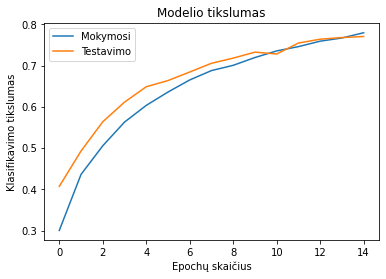

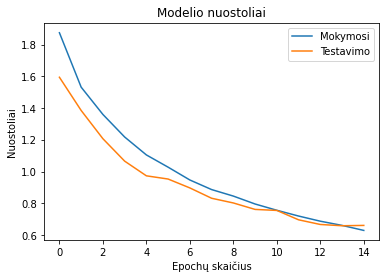

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=512, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Epoch 1/15
1500/1500 [==============================] - 31s 20ms/step - loss: 1.6959 - accuracy: 0.3721 - val_loss: 1.3715 - val_accuracy: 0.5058
Epoch 2/15
1500/1500 [==============================] - 30s 20ms/step - loss: 1.2317 - accuracy: 0.5575 - val_loss: 1.0583 - val_accuracy: 0.6230
Epoch 3/15
1500/1500 [==============================] - 30s 20ms/step - loss: 1.0279 - accuracy: 0.6339 - val_loss: 0.8855 - val_accuracy: 0.6879
Epoch 4/15
1500/1500 [==============================] - 29s 20ms/step - loss: 0.9143 - accuracy: 0.6791 - val_loss: 0.8178 - val_accuracy: 0.7097
Epoch 5/15
1500/1500 [==============================] - 30s 20ms/step - loss: 0.8364 - accuracy: 0.7076 - val_loss: 0.7391 - val_accuracy: 0.7385
Epoch 6/15
1500/1500 [==============================] - 30s 20ms/step - loss: 0.7787 - accuracy: 0.7268 - val_loss: 0.7255 - val_accuracy: 0.7506
Epoch 7/15
1500/1500 [==============================] - 30s 20ms/step - loss: 0.7307 - accuracy: 0.7439 - val_loss: 0.7039 -

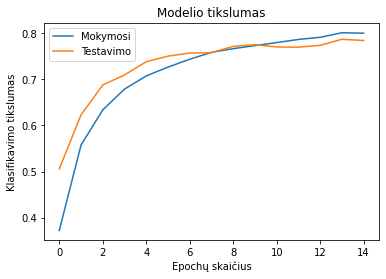

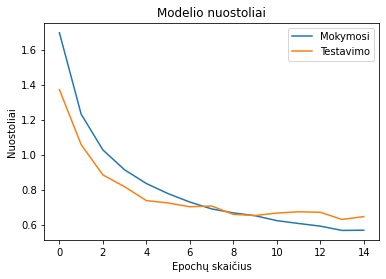

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=32, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Gauname, kad su didesniu paketo dydžiu (512) klasifikavimo tikslumas yra apie 77 %, o su mažesniu (32) - apie 78,5 %. Todėl paketo dydį paliksime 128, nes didelės įtakos nebuvo, o su mažesniu paketo dydžiu mokymosi laikas pailgėjo.

#### 3.2.3. Keičiant aktyvacijos funkciją

Pabandykime vietoje ReLu funkcijos naudoti jos modifikaciją Softplus.

In [ ]:
model_3 = Sequential()
#1 blokas
model_3.add(Conv2D(32, (3, 3), activation='softplus', padding='same', input_shape=(32, 32, 3)))
model_3.add(Conv2D(32, (3, 3), activation='softplus', padding='same'))
model_3.add(MaxPooling2D((2, 2)))
#Paliekame 80 % neuronų sluoksnyje
model_3.add(Dropout(0.2))

#2 blokas
model_3.add(Conv2D(64, (3, 3), activation='softplus', padding='same'))
model_3.add(Conv2D(64, (3, 3), activation='softplus', padding='same'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.2))

#3 blokas
model_3.add(Conv2D(128, (3, 3), activation='softplus', padding='same'))
model_3.add(Conv2D(128, (3, 3), activation='softplus', padding='same'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(128, activation='softplus'))
model_3.add(Dropout(0.2))
model_3.add(Dense(n_klasiu, activation='softmax'))

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
375/375 [==============================] - 16s 38ms/step - loss: 2.3393 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/15
375/375 [==============================] - 13s 36ms/step - loss: 2.2966 - accuracy: 0.1076 - val_loss: 2.1704 - val_accuracy: 0.2133
Epoch 3/15
375/375 [==============================] - 14s 37ms/step - loss: 1.9503 - accuracy: 0.2840 - val_loss: 1.7208 - val_accuracy: 0.3847
Epoch 4/15
375/375 [==============================] - 13s 36ms/step - loss: 1.6480 - accuracy: 0.4003 - val_loss: 1.4696 - val_accuracy: 0.4768
Epoch 5/15
375/375 [==============================] - 13s 36ms/step - loss: 1.4477 - accuracy: 0.4800 - val_loss: 1.3121 - val_accuracy: 0.5319
Epoch 6/15
375/375 [==============================] - 13s 36ms/step - loss: 1.3202 - accuracy: 0.5296 - val_loss: 1.2393 - val_accuracy: 0.5616
Epoch 7/15
375/375 [==============================] - 13s 36ms/step - loss: 1.2260 - accuracy: 0.5612 - val_loss: 1.1427 - val_accuracy:

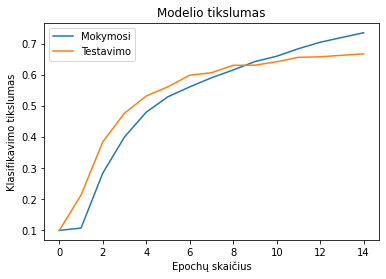

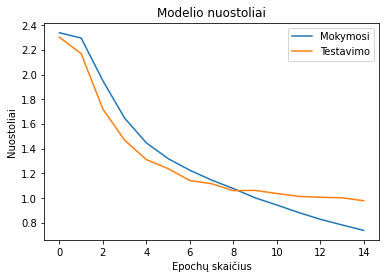

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Akivaizdu, kad Softplus funkcija netiko modeliui (klasiikavimo tikslumas nukrito iki 66,7 %).

#### 3.2.4 Keičiant optimizavimo algoritmą

Pagal straipsnį gera praktika yra stochastinis gradientinis nusileidimas su mažu mokymosi greičiu ir dideliu momentu.

In [ ]:
#Sukuriame savo stochastinio grafientinio nusileidimo algoritma su mokymosi greiciu 0,001 ir momentu 0,9 (pagal straipsni). 
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
#Taip pat naudosime kryzmine entropija kaip nuostoliu funkcija
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
375/375 [==============================] - 14s 35ms/step - loss: 2.2944 - accuracy: 0.1174 - val_loss: 2.2790 - val_accuracy: 0.1542
Epoch 2/15
375/375 [==============================] - 12s 33ms/step - loss: 2.1927 - accuracy: 0.1838 - val_loss: 2.0545 - val_accuracy: 0.2520
Epoch 3/15
375/375 [==============================] - 12s 33ms/step - loss: 2.0336 - accuracy: 0.2495 - val_loss: 1.9701 - val_accuracy: 0.2836
Epoch 4/15
375/375 [==============================] - 12s 33ms/step - loss: 1.9719 - accuracy: 0.2758 - val_loss: 1.9196 - val_accuracy: 0.3189
Epoch 5/15
375/375 [==============================] - 12s 33ms/step - loss: 1.9086 - accuracy: 0.3092 - val_loss: 1.8252 - val_accuracy: 0.3539
Epoch 6/15
375/375 [==============================] - 12s 33ms/step - loss: 1.8309 - accuracy: 0.3382 - val_loss: 1.7452 - val_accuracy: 0.3828
Epoch 7/15
375/375 [==============================] - 13s 34ms/step - loss: 1.7683 - accuracy: 0.3631 - val_loss: 1.6710 - val_accuracy:

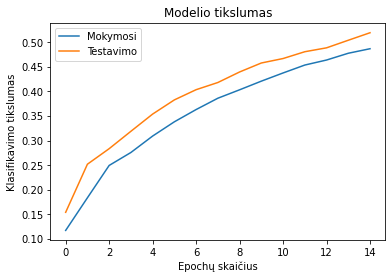

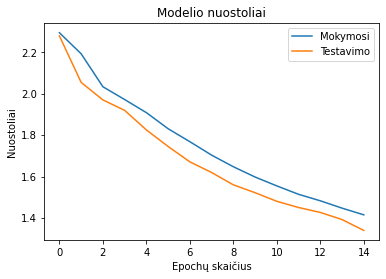

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Galbūt ir galime pasiekti didesnį klasifikavimo tikslumą mokant daugiau epochų, tačiau dabar tiesiog pabandysiu padidinti mokymosi greitį 10 kartų.

In [ ]:
#Sukuriame savo stochastinio grafientinio nusileidimo algoritma su mokymosi greiciu 0,001 ir momentu 0,9 (pagal straipsni). 
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
#Taip pat naudosime kryzmine entropija kaip nuostoliu funkcija
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
375/375 [==============================] - 13s 34ms/step - loss: 2.0282 - accuracy: 0.2495 - val_loss: 1.7733 - val_accuracy: 0.3400
Epoch 2/15
375/375 [==============================] - 12s 33ms/step - loss: 1.6505 - accuracy: 0.3975 - val_loss: 1.4592 - val_accuracy: 0.4713
Epoch 3/15
375/375 [==============================] - 12s 33ms/step - loss: 1.4468 - accuracy: 0.4755 - val_loss: 1.2902 - val_accuracy: 0.5297
Epoch 4/15
375/375 [==============================] - 13s 34ms/step - loss: 1.3045 - accuracy: 0.5299 - val_loss: 1.1586 - val_accuracy: 0.5807
Epoch 5/15
375/375 [==============================] - 12s 33ms/step - loss: 1.1899 - accuracy: 0.5751 - val_loss: 1.0695 - val_accuracy: 0.6261
Epoch 6/15
375/375 [==============================] - 12s 33ms/step - loss: 1.0801 - accuracy: 0.6176 - val_loss: 0.9513 - val_accuracy: 0.6667
Epoch 7/15
375/375 [==============================] - 12s 33ms/step - loss: 0.9878 - accuracy: 0.6483 - val_loss: 0.9010 - val_accuracy:

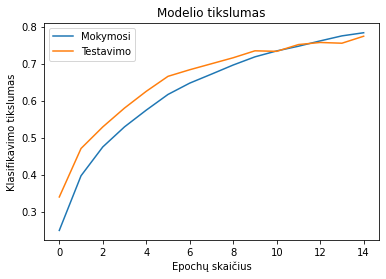

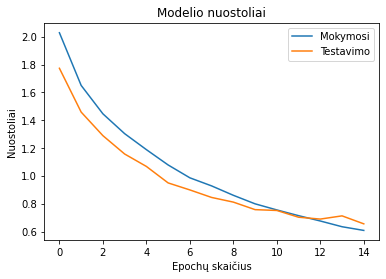

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Akivaizdu, kad su Adam algoritmu solidūs klasifikavimo tikslumai yra pasiekiami žymiai greičiau, todėl dirbant su dideliais duomenų kiekiais, kur mokymas gali trukti dienas, tai gali būti itin svarbus faktorius. 

#### 3.2.5. Keičiant nuostolių loss funkciją

Pabandysiu naudoti vidutinių kvadratinių paklaidų nuostolių funkciją.

In [ ]:
model_3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'])

Epoch 1/15
375/375 [==============================] - 13s 33ms/step - loss: 0.0755 - mse: 0.0755 - accuracy: 0.3572 - val_loss: 0.0616 - val_mse: 0.0616 - val_accuracy: 0.5203
Epoch 2/15
375/375 [==============================] - 12s 32ms/step - loss: 0.0578 - mse: 0.0578 - accuracy: 0.5517 - val_loss: 0.0522 - val_mse: 0.0522 - val_accuracy: 0.5962
Epoch 3/15
375/375 [==============================] - 12s 32ms/step - loss: 0.0503 - mse: 0.0503 - accuracy: 0.6190 - val_loss: 0.0458 - val_mse: 0.0458 - val_accuracy: 0.6576
Epoch 4/15
375/375 [==============================] - 12s 32ms/step - loss: 0.0451 - mse: 0.0451 - accuracy: 0.6637 - val_loss: 0.0398 - val_mse: 0.0398 - val_accuracy: 0.7057
Epoch 5/15
375/375 [==============================] - 12s 32ms/step - loss: 0.0409 - mse: 0.0409 - accuracy: 0.7006 - val_loss: 0.0379 - val_mse: 0.0379 - val_accuracy: 0.7203
Epoch 6/15
375/375 [==============================] - 13s 34ms/step - loss: 0.0379 - mse: 0.0379 - accuracy: 0.7247 - va

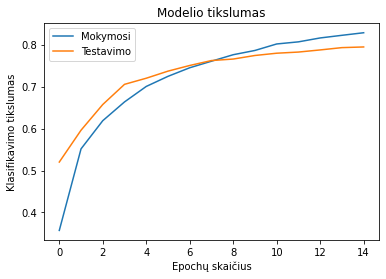

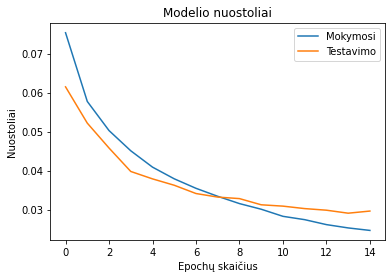

In [ ]:
istorija = model_3.fit(mok_duom, mok_pav, batch_size=128, epochs = 15, validation_data = (test_duom,test_pav), verbose = 1)
#breziame klasisifikavimo tiksluma (validacijos (pas mus testavimo) duomenims)
summarize_diagnostics(istorija)

Nors ir negavome geresnių rezultatų nei su kryžmine etropija, tačiau rezultatai vis tiek labai neblogi. Tačiau toliau nenaudosime vidutinių kvadratinių paklaidų nuostolių funkcijos.

## 4. Pavyzdžiai

Pasiliekame modelį, kuris turėjo didžiausią klasifikavimo tikslumą, t. y. iš 3.2.1 punkto (antras variantas su dropout). Pavaizduoju klasifikavimo matricą.

In [ ]:
#test_pred = model_3.predict_classes(test_duom)
test_pred=model_3.predict(test_duom)
classes_x=np.argmax(test_pred,axis=1)
print(np.argmax(test_pred, axis=1))
print(np.argmax(test_pav, axis = 1))
conf_mat = tensorflow.math.confusion_matrix(labels = np.argmax(test_pav, axis = 1), predictions = classes_x).numpy()
print(conf_mat)

[0 4 2 ... 5 9 9]
[0 4 2 ... 5 9 2]
[[1006   19   35   22   10   20   11    9   31   37]
 [  11 1095    3    5    0    2    7    1    6   70]
 [  77    7  814   39   80   74   75   16    7   11]
 [  18    8   33  662   63  276   88   31    5   16]
 [  24    3   42   49  926   37   50   57    5    7]
 [   2    1   30  107   37  952   29   36    1    5]
 [   5    4   34   28   31   31 1052    2    7    6]
 [  15    2   21   33   35   62   10 1017    0    5]
 [  80   47    8   13    1    4   14    3  996   34]
 [  21   48    3   10    2    3    6    5    6 1096]]


Kiekviename matricos įstižainės langelyje idealiu atveju turėjo būti 1200 reikšmių. Tačiau akivaizdu, kad apie 20 % duomenų buvo suklasifikuota neteisingai, tai parodo ir  klasifikavimo matrica. Neuroniniai tinklai blogiausiai surūšiavo katinukus, kur tik 662 buvo teisingai suklasifikuoti paveiksliukai, o didelė dalis buvo priskiriama šunims. Tačiau tai nestebina, nes nuotraukų kokybė kartais sumaišo net ir mane patį. Tiksliausiai klasifikuoijami buvo sunkvežimiai, kur tik 8,7 % buvo suklasifikuota neteisingai. \\
Dabar atrinksime 30 pavyzdžių iš mūsų testavimo aibės.

In [ ]:
#sujungiame paveiksliukus su pavadinimais
zip_pavyzd_duom = list(zip(test_duom, test_pav))
#sumaisome atsitiktine tvarka
random.shuffle(zip_pavyzd_duom)
#isskleidziame i naujus kintamuosius, kurie sumaisyti kita tvarka nei test_duom
pavyzd_duom, pavyzd_pav = zip(*zip_pavyzd_duom)
pavyzd_duom = np.asarray(pavyzd_duom)
pavyzd_pav = np.asarray(pavyzd_pav)
#Pasiliekame tik pirmas 30 reiksmiu
type(pavyzd_duom)
pavyzd_duom = pavyzd_duom[:30]
pavyzd_pav = pavyzd_pav[:30]

print(pavyzd_duom.shape)
print(pavyzd_pav.shape)

(30, 32, 32, 3)
(30, 10)


Tikimybe | Nustatyta klase | Teisinga klase
99.94974 |	    8 |	    8
99.99977 |	    8 |	    8
99.95149 |	    1 |	    1
99.98832 |	    8 |	    8
99.99797 |	    9 |	    9
100.0 |	    9 |	    9
99.970146 |	    1 |	    1
99.99506 |	    6 |	    6
82.530624 |	    5 |	    5
81.13329 |	    3 |	    3
99.68345 |	    7 |	    7
99.94863 |	    6 |	    6
48.655415 |	    4 |	    4
68.62163 |	    8 |	    1


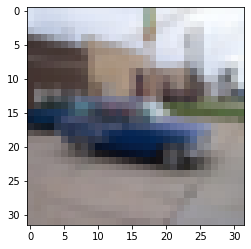

63.94574 |	    2 |	    5


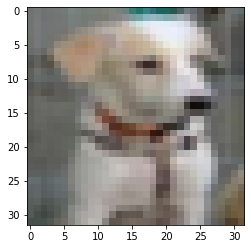

99.99998 |	    8 |	    8
99.725334 |	    6 |	    6
99.74898 |	    7 |	    7
77.74795 |	    0 |	    2


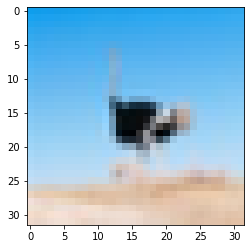

97.513916 |	    2 |	    4


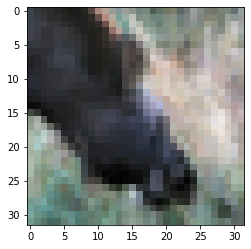

99.99996 |	    7 |	    7
76.81769 |	    2 |	    3


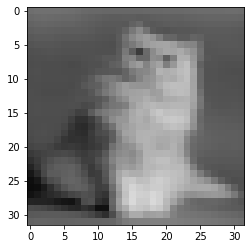

99.99846 |	    1 |	    1
99.99989 |	    9 |	    9
99.971886 |	    8 |	    8
56.16157 |	    4 |	    3


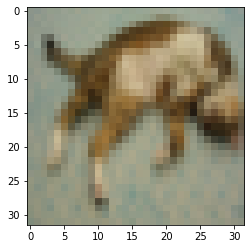

99.9869 |	    4 |	    4
99.99998 |	    0 |	    0
42.533936 |	    1 |	    9


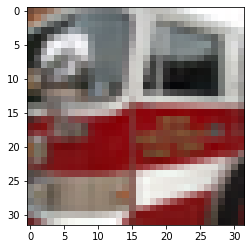

80.43327 |	    4 |	    4


In [ ]:
#Kad skaiciai butu po kablelio
np.set_printoptions(suppress=True)
print("Tikimybe |", "Nustatyta klase |", "Teisinga klase")
#iteruojame per 30 paveiksleliu
for i in range(30):
  paveiksliukas = pavyzd_duom[i]
  #pridedame dar viena dimensija (kitaip meta klaida)
  paveiksliukas = paveiksliukas.reshape(1, 32, 32, 3)
  #randame priskirimo tikimybes
  tikimybes = model_3.predict(paveiksliukas)*100
  tikimybes = tikimybes[0]
  #randame didziausia tikimybe ir jos indeksa (kuris parodo mums kuri klase buvo priskirta paveiksleliui)
  didz_tik = np.amax(tikimybes)
  indeksas = np.argmax(tikimybes)

  #randame tikra atsakyma (vel pagal indeksa (nes visur 0, tik vienintelis 1))
  teis_ats = np.argmax(pavyzd_pav[i])
  print(didz_tik, '|\t   ', indeksas, '|\t   ', teis_ats)
  if teis_ats != indeksas:
    plt.imshow(pavyzd_duom[i])
    plt.show()

Prisiminkime, ką koks skaičius simbolizuoja: \\
0	lėktuvas \\
1	mašina \\
2	paukštis \\
3	katė \\
4	elnias \\
5	šuo \\
6	varlė \\
7	arklys \\
8	laivas \\
9	sunkvežimis \\
Taigi mūsų pavyzdyje algoritmas teisingai suklasifikavo tik 23 iš 30 paveiksliukų, tačiau kai kurie iš jų - tikrai sunkiai atskiriami.

## 5. Išvados

Iš šio tyrimo matome, kad net ir gana lengvai užrašomas neuroninis tinklas gali neblogai atlikti savo užduotį. Yra sudarytos optimaliausios modelių schemos, kurios leidžia tai pasiekti. Nors mano mokymai truko tik apie 2 - 3 minutes, tačiau dėl šiuolaikinių galimybių kaip GPU naudojimas, mūsų užduočiai to visiškai pakako (pastaba: bandžius mokyti neįjungus GPU viena epocha trukdavo apie 4 kartus ilgiau). Modelį galima bandyti toliau tobulinti, optimizuoti. Implementavimas duomenų padidinimo (augmentation), derinimas išmetamų neuronų dalies (dropout) bei svorių reguliavimas gali turėti įtakos klasifikavimo tikslumui.